<h3 style="text-align: center;"><b>2 сценарий</b></h3>

Во втором сценарии упор делается на сбор выборки, преобработку данных, обучение модели и измерение качества её работы. То есть осуществляется полный цикл разработки нейросетевой модели для задачи детектирования без встривания в веб/мобильный прототип.

**Выбор датасета**

Был использован датасет "Фрукты" 

https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

Скачали, нажав на кнопку Download.
Проверим содержимое.

In [1]:
!ls '../input/fruit-images-for-object-detection/train_zip/train'

apple_1.jpg   apple_54.jpg   banana_31.jpg  banana_75.jpg  orange_31.jpg
apple_1.xml   apple_54.xml   banana_31.xml  banana_75.xml  orange_31.xml
apple_10.jpg  apple_55.jpg   banana_32.jpg  banana_76.jpg  orange_32.jpg
apple_10.xml  apple_55.xml   banana_32.xml  banana_76.xml  orange_32.xml
apple_11.jpg  apple_56.jpg   banana_33.jpg  banana_8.jpg   orange_33.jpg
apple_11.xml  apple_56.xml   banana_33.xml  banana_8.xml   orange_33.xml
apple_12.jpg  apple_57.jpg   banana_34.jpg  banana_9.jpg   orange_34.jpg
apple_12.xml  apple_57.xml   banana_34.xml  banana_9.xml   orange_34.xml
apple_13.jpg  apple_58.jpg   banana_35.jpg  mixed_1.jpg    orange_35.jpg
apple_13.xml  apple_58.xml   banana_35.xml  mixed_1.xml    orange_35.xml
apple_14.jpg  apple_59.jpg   banana_36.jpg  mixed_10.jpg   orange_36.jpg
apple_14.xml  apple_59.xml   banana_36.xml  mixed_10.xml   orange_36.xml
apple_15.jpg  apple_6.jpg    banana_37.jpg  mixed_11.jpg   orange_37.jpg
apple_15.xml  apple_6.xml    banana_37.xml  mixed_1

In [2]:
!ls '../input/fruit-images-for-object-detection/test_zip/test'

apple_77.jpg  apple_89.jpg   banana_82.jpg  banana_94.jpg  orange_83.jpg
apple_77.xml  apple_89.xml   banana_82.xml  banana_94.xml  orange_83.xml
apple_78.jpg  apple_90.jpg   banana_83.jpg  mixed_21.jpg   orange_84.jpg
apple_78.xml  apple_90.xml   banana_83.xml  mixed_21.xml   orange_84.xml
apple_79.jpg  apple_91.jpg   banana_84.jpg  mixed_22.jpg   orange_85.jpg
apple_79.xml  apple_91.xml   banana_84.xml  mixed_22.xml   orange_85.xml
apple_80.jpg  apple_92.jpg   banana_85.jpg  mixed_23.jpg   orange_86.jpg
apple_80.xml  apple_92.xml   banana_85.xml  mixed_23.xml   orange_86.xml
apple_81.jpg  apple_93.jpg   banana_86.jpg  mixed_24.jpg   orange_87.jpg
apple_81.xml  apple_93.xml   banana_86.xml  mixed_24.xml   orange_87.xml
apple_82.jpg  apple_94.jpg   banana_87.jpg  mixed_25.jpg   orange_89.jpg
apple_82.xml  apple_94.xml   banana_87.xml  mixed_25.xml   orange_89.xml
apple_83.jpg  apple_95.jpg   banana_88.jpg  orange_77.jpg  orange_90.jpg
apple_83.xml  apple_95.xml   banana_88.xml  orange_

Функция, которая получает на вход .xml файл с PASCAL-VOC разметкой bbox'ов и возвращает list, состоящий из координат боксов 

In [3]:
import xml.etree.ElementTree as ET

def xml_to_list(path):
    xml_list = []
    for xml_file in glob.glob(path):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    return xml_list

Вместо torchvision.transforms будет использовано albumentations, так как albumentations применяется не только к изображениям, но и к bbox'ам.

In [4]:
! pip install -U albumentations

**Предобработка данных**

Класс Dataset используется для предварительной обработки данных.

In [6]:
import os
import numpy as np
import torch
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import albumentations as albu
from albumentations.pytorch import ToTensorV2
    

SEED = 4242 # для воспроизводимости результатов
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)


class PrepareDataset(Dataset):
    def __init__(self, root, mode):
        self.root = root
        self.mode = mode
        
        self.imgs = list(sorted(glob.glob(os.path.join(root + '/*.jpg'))))
        self.boxes = list(sorted(glob.glob(os.path.join(root + '/*.xml'))))

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        box_path = self.boxes[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.asarray(img)
        box_list = xml_to_list(box_path)

        annotations = {'image': img,
                       'bboxes': [],
                       'category_id': []}
        for i in range(len(box_list)):
            xmin = box_list[i][4]
            xmax = box_list[i][6]
            ymin = box_list[i][5]
            ymax = box_list[i][7]
            label = box_list[i][3]
            if label == 'apple':
                annotations['category_id'].append(1)
            elif label == 'banana':
                annotations['category_id'].append(2)
            else:
                annotations['category_id'].append(3)
            annotations['bboxes'].append([xmin, ymin, xmax, ymax])
        
        if self.mode == 'train':
            self.transforms = [albu.HorizontalFlip(),
                               albu.Flip()]
        else:
            self.transforms = []

        # Дополнительные аугментации для 'banana' в train
        if any(label == 2 for label in annotations['category_id']) and self.mode == 'train':
            self.transforms.append(albu.RandomGamma(p=1))
            self.transforms.append(albu.RandomBrightness(limit=0.1))
            self.transforms.append(albu.RandomContrast(limit=0.15))
        
        self.transforms.append(ToTensorV2())
        self.transforms = albu.Compose(self.transforms, bbox_params=albu.BboxParams(format='pascal_voc', label_fields=['category_id'])) 
        if self.transforms is not None:
            annotations = self.transforms(**annotations)
        
        boxes = []
        for i, box in enumerate(annotations['bboxes']):
            annotations['bboxes'][i] = list(box)

        boxes = torch.as_tensor(annotations['bboxes'], dtype=torch.float32)

        image = annotations['image']
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(annotations['category_id'], dtype=torch.int64)

        return {'I': image,
                'T': target}

    def __len__(self):
        return len(self.imgs)

Используется сеть Faster R-CNN.

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 3 classes (apple, banana, orange) + background
num_classes = 3 + 1

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Используем collate_fn для батча.

In [8]:
def collate_fn(batch):
    return batch

In [9]:
DIR_train = '../input/fruit-images-for-object-detection/train_zip/train'
DIR_test = '../input/fruit-images-for-object-detection/test_zip/test'

Создаем даталоадеры для train, val, и test выборок.

In [10]:
dataset_train = PrepareDataset(DIR_train, mode='train')
dataset_test = PrepareDataset(DIR_test, mode='test')

# Let's get validation test 
train_set, valid_set = torch.utils.data.random_split(dataset_train, [190, 50])

data_loader_train = torch.utils.data.DataLoader(
 train_set, batch_size=5, shuffle=True, collate_fn=collate_fn)

data_loader_val = torch.utils.data.DataLoader(
 valid_set, batch_size=1, shuffle=False, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [11]:
print('Amount of train samples = ', len(train_set))
print('Amount of val samples = ', len(valid_set))
print('Amount of test samples = ', len(dataset_test))

Amount of train samples =  190
Amount of val samples =  50
Amount of test samples =  60


Функции для отрисовки боксов на изображениях.

In [12]:
import cv2
import matplotlib.pyplot as plt


BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[int(class_id)]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(image, target, category_id_to_name={1: 'apple', 2: 'banana', 3: 'orange'}):
    img = image.cpu().numpy().transpose(1, 2, 0).copy()
    for idx, box in enumerate(target['boxes']):
        img = visualize_bbox(img, box, target['labels'][idx], category_id_to_name, color=BOX_COLOR, thickness=2)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

Отобразим для примера одну картинку с размеченными боксами.

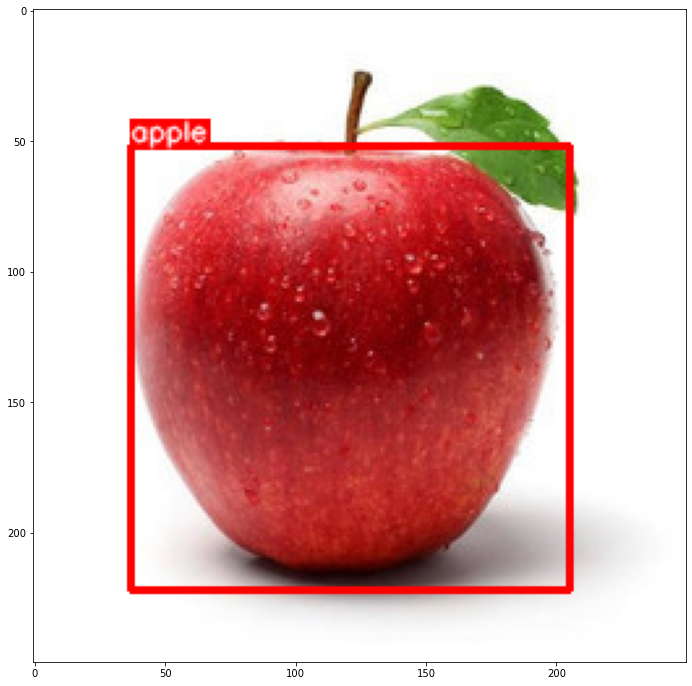

In [13]:
sample = dataset_train.__getitem__(11)
sample_image = sample['I']
sample_target = sample['T']

visualize(sample_image, sample_target)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [5, 10, 15, 25], gamma=0.1)

**Обучение модели-детектора**

In [23]:
def train(model, optimizer, lr_scheduler, epochs, saving_freq): 
    model.train()
    losses_history_train = {'loss_classifier': [],
                       'loss_box_reg': [],
                       'loss_objectness': [],
                       'loss_rpn_box_reg': []}
    losses_history_val = {'loss_classifier': [],
                       'loss_box_reg': [],
                       'loss_objectness': [],
                       'loss_rpn_box_reg': []}
                       
    for epoch in range(epochs):
        loss_values_train = {'loss_classifier': 0,
                       'loss_box_reg': 0,
                       'loss_objectness': 0,
                       'loss_rpn_box_reg': 0}
        loss_values_val = {'loss_classifier': 0,
                       'loss_box_reg': 0,
                       'loss_objectness': 0,
                       'loss_rpn_box_reg': 0}

        # Train
        for i, data in enumerate(data_loader_train):
            images = []
            targets = []
            for elem in data:
                images.append(elem['I'].float().div(255).to(device)) 
                targets.append({k: v.to(device) for k, v in elem['T'].items()})
            
            loss_dict = model(images, targets)
            for loss_name, loss_value in zip(loss_dict.keys(), loss_dict.values()):
                loss_values_train[loss_name] += loss_value.item()
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        data_length_train = len(data_loader_train)
        for k in losses_history_train.keys():
            losses_history_train[k].append(loss_values_train[k] / data_length_train)

        # Validation
        for i, data in enumerate(data_loader_val):
            with torch.no_grad():
                images = []
                targets = []
                for elem in data:
                    images.append(elem['I'].float().div(255).to(device))
                    targets.append({k: v.to(device) for k, v in elem['T'].items()})
                    
                loss_dict = model(images, targets)
                for loss_name, loss_value in zip(loss_dict.keys(), loss_dict.values()):
                    loss_values_val[loss_name] += loss_value.item()

        data_length_val = len(data_loader_val)
        for k in losses_history_val.keys():
            losses_history_val[k].append(loss_values_val[k] / data_length_val)

        lr_scheduler.step()
        
        if (epoch+1) % saving_freq == 0 or (epoch+1) == epochs:
            torch.save(model.state_dict(), f'../weigths_at_epoch_{epoch+1}.pth')

        print('########################')
        print(f'Epoch {epoch+1} is done')
        print('Loss values for TRAIN:')
        for k, v in zip(loss_values_train.keys(), loss_values_train.values()):
            print('\t\t {} = {:.4f}'.format(k, v / data_length_train))
        print('Loss values for VALIDATION:')
        for k, v in zip(loss_values_val.keys(), loss_values_val.values()):
            print('\t\t {} = {:.4f}'.format(k, v / data_length_val))
        print('########################')

    return losses_history_train, losses_history_val

In [24]:
losses_history_train, losses_history_val = train(model, optimizer, lr_scheduler, epochs=100, saving_freq=8)

########################
Epoch 1 is done
Loss values for TRAIN:
		 loss_classifier = 0.0604
		 loss_box_reg = 0.0893
		 loss_objectness = 0.0030
		 loss_rpn_box_reg = 0.0066
Loss values for VALIDATION:
		 loss_classifier = 0.1139
		 loss_box_reg = 0.1659
		 loss_objectness = 0.0050
		 loss_rpn_box_reg = 0.0096
########################
########################
Epoch 2 is done
Loss values for TRAIN:
		 loss_classifier = 0.0606
		 loss_box_reg = 0.0886
		 loss_objectness = 0.0029
		 loss_rpn_box_reg = 0.0066
Loss values for VALIDATION:
		 loss_classifier = 0.1088
		 loss_box_reg = 0.1604
		 loss_objectness = 0.0047
		 loss_rpn_box_reg = 0.0092
########################
########################
Epoch 3 is done
Loss values for TRAIN:
		 loss_classifier = 0.0595
		 loss_box_reg = 0.0907
		 loss_objectness = 0.0029
		 loss_rpn_box_reg = 0.0064
Loss values for VALIDATION:
		 loss_classifier = 0.1169
		 loss_box_reg = 0.1640
		 loss_objectness = 0.0064
		 loss_rpn_box_reg = 0.0099
##############

Отобразим на графике изменения лоссов.

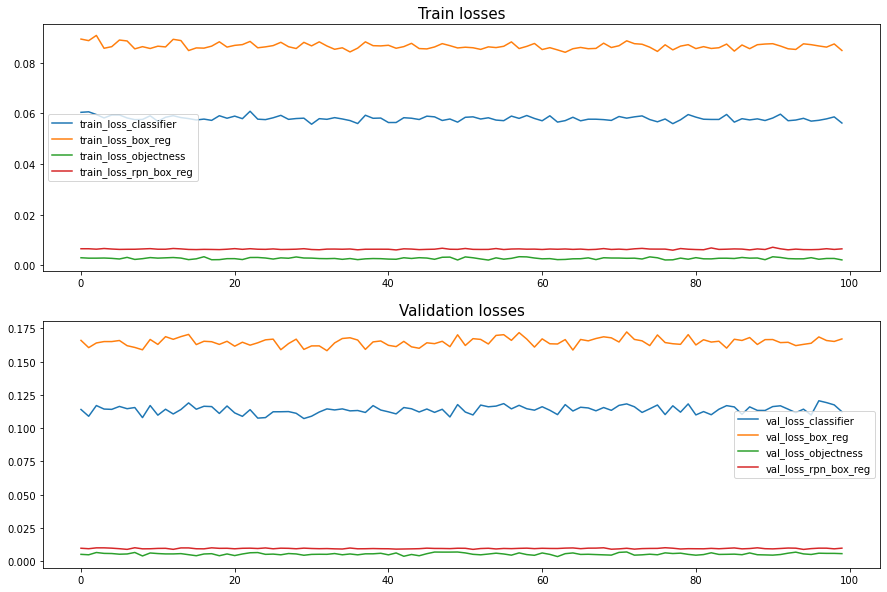

In [25]:
losses_history_train_lc = losses_history_train['loss_classifier']
losses_history_train_br = losses_history_train['loss_box_reg']
losses_history_train_obj = losses_history_train['loss_objectness']
losses_history_train_rpn = losses_history_train['loss_rpn_box_reg']

losses_history_val_lc = losses_history_val['loss_classifier']
losses_history_val_br = losses_history_val['loss_box_reg']
losses_history_val_obj = losses_history_val['loss_objectness']
losses_history_val_rpn = losses_history_val['loss_rpn_box_reg']



fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

axes[0].plot(losses_history_train_lc, label='train_loss_classifier')
axes[0].plot(losses_history_train_br, label='train_loss_box_reg')
axes[0].plot(losses_history_train_obj, label='train_loss_objectness')
axes[0].plot(losses_history_train_rpn, label='train_loss_rpn_box_reg')
axes[0].legend(loc='best')
axes[0].set_title('Train losses', fontsize=15)

axes[1].plot(losses_history_val_lc, label='val_loss_classifier')
axes[1].plot(losses_history_val_br, label='val_loss_box_reg')
axes[1].plot(losses_history_val_obj, label='val_loss_objectness')
axes[1].plot(losses_history_val_rpn, label='val_loss_rpn_box_reg')
axes[1].legend(loc='best')
axes[1].set_title('Validation losses', fontsize=15)

plt.show()

In [ ]:
# model.load_state_dict(torch.load('../weigths_at_epoch_5.pth'))

In [26]:
def iou_score(boxA, boxB):
    boxA = boxA.tolist()
    boxB = boxB.tolist()
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def classify(predicted_boxes, target_boxes):
    TP, FP, FN = 0, 0, 0
    len_pr_boxes = len(predicted_boxes)
    len_tr_boxes = len(target_boxes)
    # create matrix (len_tr_boxes, len_pr_boxes). In rows IoU of target box with predict box, in cols IoU of predict with target
    iou_matrix = np.zeros((len_tr_boxes, len_pr_boxes))
    for i in range(iou_matrix.shape[0]):
        for j in range(iou_matrix.shape[1]):
            iou_matrix[i][j] = iou_score(target_boxes[i], predicted_boxes[j])
    # threshold 0.5 for IoU score
    iou_matrix = 1 * (iou_matrix > 0.5)
    # sum by col-axis, it gives amount of predicted boxes that aims target boxes by IoU score > 0.5
    iou_matrix = np.sum(iou_matrix, axis=1)
    for i in range(iou_matrix.shape[0]):
        if iou_matrix[i] == 0:
            FN += 1
        elif iou_matrix[i] == 1:
            TP += 1
        else:
            TP += 1
            FP += iou_matrix[i] - 1
    if np.sum(iou_matrix) <= len_pr_boxes:
        FP += len_pr_boxes - np.sum(iou_matrix)
    conf_mat = {}
    conf_mat['TP'] = TP
    conf_mat['FP'] = FP
    conf_mat['FN'] = FN
    return conf_mat

**Измерение качества работы модели**

In [29]:
def metric(model, dataset_loader):
    # class 1 - apple, class 2 - banana, class 3 - orange
    confusion_matrix = {1: {'TP': 0, 'FP': 0, 'FN': 0},
                        2: {'TP': 0, 'FP': 0, 'FN': 0},
                        3: {'TP': 0, 'FP': 0, 'FN': 0}}

    with torch.no_grad():
      model.eval()
      for i, data in enumerate(dataset_loader):
          image = []
          target = []
          for elem in data:
              image.append(elem['I'].float().div(255).to(device))
              target.append({k: v.to(device) for k, v in elem['T'].items()})
          prediction = model(image)

          CONF_THRESH = 0.85
          predicted_boxes = prediction[0]['boxes'][prediction[0]['scores'] > CONF_THRESH]
          predicted_labels = prediction[0]['labels'][prediction[0]['scores'] > CONF_THRESH]
          dict_predicted = {}
          dict_predicted['boxes'] = predicted_boxes.cpu()
          dict_predicted['labels'] = predicted_labels.cpu()
 
          dict_target = {}
          dict_target['boxes'] = target[0]['boxes'].cpu()
          dict_target['labels'] = target[0]['labels'].cpu()

          conf_matrix = {}
          for classes in range(1, 4):
              conf_matrix[classes] = classify(dict_predicted['boxes'][dict_predicted['labels'] == classes], dict_target['boxes'][dict_target['labels'] == classes])
              confusion_matrix[classes]['TP'] += conf_matrix[classes]['TP']
              confusion_matrix[classes]['FP'] += conf_matrix[classes]['FP']
              confusion_matrix[classes]['FN'] += conf_matrix[classes]['FN']
                        
    return confusion_matrix

In [30]:
confusion_matrix = metric(model, data_loader_test)

In [34]:
class_1 = confusion_matrix[1]
class_2 = confusion_matrix[2]
class_3 = confusion_matrix[3]

# precision
precision_1 = class_1['TP'] / (class_1['TP'] + class_1['FP'])
precision_2 = class_2['TP'] / (class_2['TP'] + class_2['FP'])
precision_3 = class_3['TP'] / (class_3['TP'] + class_3['FP'])

# recall
recall_1 = class_1['TP'] / (class_1['TP'] + class_1['FN'])
recall_2 = class_2['TP'] / (class_2['TP'] + class_2['FN'])
recall_3 = class_3['TP'] / (class_3['TP'] + class_3['FN'])

# f1
f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
f1_score_2 = 2 * (precision_2 * recall_2) / (precision_2 + recall_2)
f1_score_3 = 2 * (precision_3 * recall_3) / (precision_3 + recall_3)

# avg_precision
avg_precision = []
average_precision_1 = (precision_1 + recall_1) / 2
average_precision_2 = (precision_2 + recall_2) / 2
average_precision_3 = (precision_3 + recall_3) / 2

avg_precision.append(average_precision_1)
avg_precision.append(average_precision_2)
avg_precision.append(average_precision_3)

# mAP
mAP = (average_precision_1 + average_precision_2 + average_precision_3) / len(avg_precision)

# Вывод
print('Class 1. Precision = ', precision_1, 'Recall = ', recall_1, 'TP = ', class_1['TP'], 'FP = ', class_1['FP'], 'FN = ', class_1['FN'], 'F1_score = ', f1_score_1, 'AVG_PRECISION = ', average_precision_1)
print('Class 2. Precision = ', precision_2, 'Recall = ', recall_2, 'TP = ', class_2['TP'], 'FP = ', class_2['FP'], 'FN = ', class_2['FN'], 'F1_score = ', f1_score_2, 'AVG_PRECISION = ', average_precision_2)
print('Class 3. Precision = ', precision_3, 'Recall = ', recall_3, 'TP = ', class_3['TP'], 'FP = ', class_3['FP'], 'FN = ', class_3['FN'], 'F1_score = ', f1_score_3, 'AVG_PRECISION = ', average_precision_3)
print('mAP = ', mAP)

Class 1. Precision =  0.9310344827586207 Recall =  0.7714285714285715 TP =  27 FP =  2 FN =  8 F1_score =  0.8437500000000001 AVG_PRECISION =  0.8512315270935961
Class 2. Precision =  0.7142857142857143 Recall =  0.5 TP =  20 FP =  8 FN =  20 F1_score =  0.588235294117647 AVG_PRECISION =  0.6071428571428572
Class 3. Precision =  1.0 Recall =  0.5952380952380952 TP =  25 FP =  0 FN =  17 F1_score =  0.7462686567164178 AVG_PRECISION =  0.7976190476190477
mAP =  0.7519978106185002


**Выводы.**

**Для класса 1**: модель имеет высокую точность (0.93), но низкую полноту (0.77), т.е. она часто предсказывает правильные классы, но не всегда. F1-мера (0.84) показывает, что баланс между точностью и полнотой не очень хороший.
    
**Для класса 2**: модель имеет низкую точность (0.71) и полноту (0.5), т.е. она не часто предсказывает правильные классы, и когда предсказывает, это не часто верно. F1-мера (0.59) показывает, что это очень плохой баланс.
    
**Для класса 3**: модель имеет идеальную точность (1.0), но недостаточно высокую полноту (0.60), т.е. она всегда предсказывает правильные классы, но не всегда учитывает все данные. F1-мера (0.75) показывает, что это хороший баланс.
    
**mAP (mean Average Precision)** показывает среднее качество предсказаний модели для всех классов и получнное значение означает, что средняя точность модели равна 75.2%

**Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо**

Модель может быть использована в системах автоматизированной проверки качества овощей на складах или в фабриках пищевой промышленности.

Встраивание модели в мобильное приложение для покупателей может помочь выбрать качественные овощи на рынке.

Модель может быть использована в веб-сервисе для онлайн-заказа продуктов питания, чтобы гарантировать, что покупатель получит только качественные овощи.